###  Simple Autoencoder and VAE on the MNIST dataset


Here is a working demo of an autoencoder and a VAE for the MNIST dataset, mostly copy pasted and adapted from a blog. 

In [3]:
import torch
import torch.nn as nn
import torch.distributions
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import numpy as np
import torchvision
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# pixel height and width of the MNIST dataset images
image_size = 28

cuda


In [17]:
class Encoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim):
        super().__init__()
        self.input_dim = image_size*image_size
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x,start_dim=1) # the input is a batch of 2D images, we flatten each image to a vector
        x = self.relu(self.fc1(x))
        return self.fc2(x)
    

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = image_size*image_size
        self.fc1 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        self.relu = nn.ReLU()

    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.view(-1, 1, image_size, image_size) # reshape to a batch of 2D images of size image_size*image_size
    

class Autoencoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, hidden_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [16]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(),lr=1e-3)
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [12]:
latent_dims = 2
hidden_dims =512
autoencoder = Autoencoder(latent_dims,hidden_dims).to(device) # GPU

In [13]:
# we load the MNIST dataset from torchvision
# no train / test split, we use all the data for training - this is not a good idea in general
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [ ]:
autoencoder = train(autoencoder, data)
print('nb of params : {}'.format(count_parameters(autoencoder)))

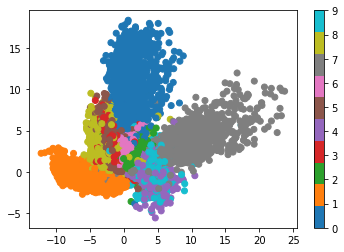

In [23]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        try :
            z,_ = autoencoder.encoder(x.to(device))
        except :
            z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(autoencoder, data)

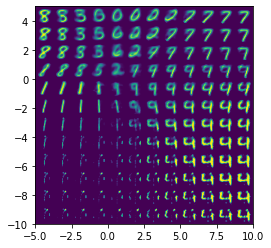

In [24]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            try :
                x_hat,_ = autoencoder.decoder(z)
            except:
                x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(autoencoder)

In [25]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim):
        super(VariationalEncoder,self).__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)

        self.N = torch.distributions.Normal(0,1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x,start_dim=1)
        x = torch.relu(self.fc1(x))
        mu = self.fc2(x)
        log_sigma = self.fc3(x)
        sigma = torch.exp(log_sigma)
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - log_sigma - 1/2).sum() # formula for KL-divergence between N(mu,sigma) and N(0,1)
        return z, sigma
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dim,hidden_dim)
        self.decoder = Decoder(latent_dim, 512)

    def forward(self, x):
        z,sigma = self.encoder(x)
        return self.decoder(z),sigma

In [32]:
def train_vae(autoencoder, data, epochs=5):
    sigmas = [] # we store the standard deviation of the latent space as training progresses
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat, sigma = autoencoder(x)
            sigmas.append(sigma.cpu().detach().numpy()[0])
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder,sigmas

In [28]:
vae = VariationalAutoencoder(latent_dims,hidden_dims).to(device)
print('nb of params : {}'.format(count_parameters(autoencoder)))

nb of params : 806674


In [64]:
vae,sigmas = train_vae(vae, data)

100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


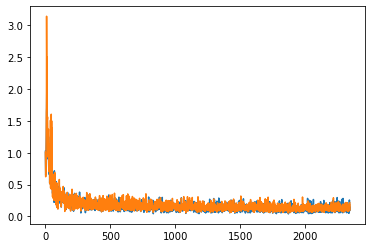

In [31]:
plt.plot(sigmas)

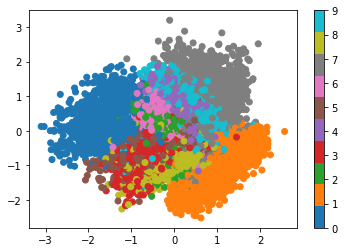

In [33]:
plot_latent(vae, data)

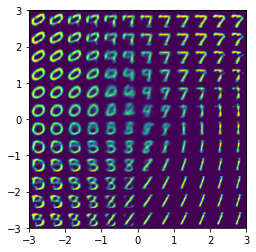

In [35]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

Let's see what does the VAE do to a random image

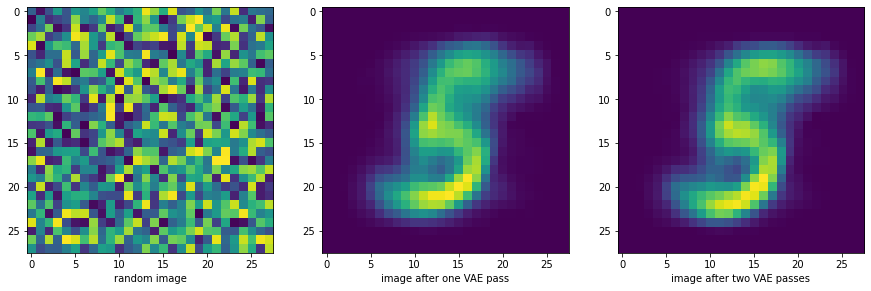

sigma after one pass : [[0.17363432 0.24282953]]
sigma after two passes : [[0.14731914 0.1682638 ]]


In [83]:
rd_img = np.random.uniform(size=(28,28)).astype(np.float32)

reconstruct_rd_img,r_sigma = vae(torch.tensor([[rd_img]]).to(device))
reconstruct_rd_img = reconstruct_rd_img.detach().cpu().numpy()[0,0]

reconstruct_reconstruct_rd_img,r_r_sigma = vae(torch.tensor([[reconstruct_rd_img]]).to(device))
reconstruct_reconstruct_rd_img = reconstruct_reconstruct_rd_img.detach().cpu().numpy()[0,0]

f = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rd_img)
plt.xlabel('random image')

plt.subplot(1,3,2)
plt.imshow(reconstruct_rd_img)
plt.xlabel('image after one VAE pass')

plt.subplot(1,3,3)
plt.imshow(reconstruct_reconstruct_rd_img)
plt.xlabel('image after two VAE passes')

plt.show()

print('sigma after one pass : {}'.format(r_sigma.detach().cpu().numpy()))
print('sigma after two passes : {}'.format(r_r_sigma.detach().cpu().numpy()))

the variance of the posterior over latent space is high when the image is random, and decrease when the inputs looks more like a digit